## Texas Ensemble Analysis

This notebook walks through analyzing and visualizing metrics based on ensembles formed from running MCMC chains using different parameter configurations. 4 chains are analyzed below:

* 2010 Base Ensemble of Plans 
* 2010 VRA Conscious Ensemble of Plans _(set ensemble_inclusion = True in 03_TX_model.py)_
* 2020 Base Ensemble of Plans 
* 2020 VRA Conscious Ensemble of Plans _(set ensemble_inclusion = True in 03_TX_model.py)_

The 2010 ensembles use population estimates from the 2010 Census, and are based on plans with 36 congressional districts. The 2020 ensembles use population estimates from the 2019 ACS Survey since 2020 Census results were not available during the time of analysis, and are based on plans with 38 congressional districts.



In [137]:
import sys
import os

from functools import partial
import random

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import adjustText as aT

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
    tree
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random, PopulatedGraph, \
                            find_balanced_edge_cuts_memoization, random_spanning_tree
import maup

import networkx as nx

import warnings 
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

#### Read in Data

Shapefile & Plan Metrics captured during MCMC run for the 4 chains

In [224]:
state_gdf = gpd.read_file("Data/TX_VTDs_POP2019/texas_population2019.shp")

In [143]:
vra_2010 = pd.read_csv('Outputs/map_metric_Texas_2010_run_county_aware_proposal_inclusion.csv')
vra_2019 = pd.read_csv('Outputs/map_metric_Texas_2019_run_county_aware_proposal_inclusion.csv')

base_2010 = pd.read_csv('Outputs/map_metric_Texas_2010_run_county_aware_proposal.csv')
base_2019 = pd.read_csv('Outputs/map_metric_Texas_2019_run_county_aware_proposal.csv')


vra_2010.head()

,Unnamed: 0,Latino_state,Black_state,Distinct_state,Latino_equal,Black_equal,Distinct_equal,Latino_dist,Black_dist,Distinct_dist,Cut Edges,County Splits
0,0,8,4,11,8,4,11,NaN,NaN,NaN,3356,30
1,1,8,4,11,8,4,11,NaN,NaN,NaN,3385,31
2,2,8,4,11,8,4,11,NaN,NaN,NaN,3389,32
3,3,8,4,11,8,4,11,NaN,NaN,NaN,3410,37
4,4,8,4,11,8,4,11,NaN,NaN,NaN,3421,37


## VRA Conscious Ensembles

Using GerryChain we are able to examine how a VRA conscious ensemble compares to a base ensemble of plans that only considers population balance, contiguity, and county line preservation goals. As shown in the two graphs below, if we add an additional constraint when designing plans that preferentially selects plans with more minority effective districts, we would be able to design plans that have 2 to 3 more minority effective districts on average based on the 2010 population data.

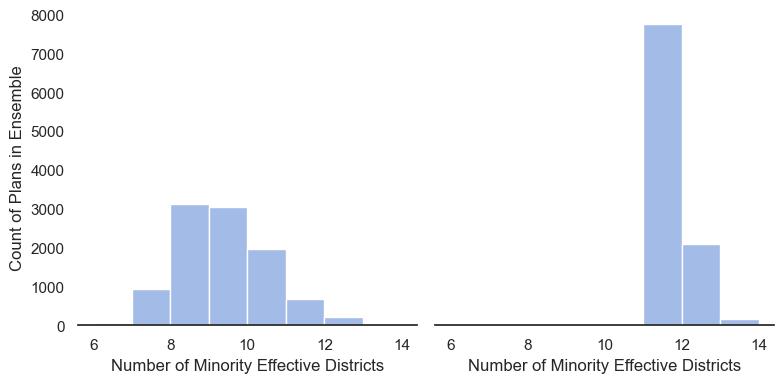

In [230]:
sns.set(style="white", palette="muted", color_codes=True)


# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.despine(left=True)

ax1 = sns.histplot(distinct_state['2010 Base Plan'], bins=list(range(6,15)), alpha = .5, ax=axes[0])
ax1.set(#title='Base Plan (2010)', 
        xlabel='Number of Minority Effective Districts',
        ylabel='Count of Plans in Ensemble'
       )

ax2 = sns.histplot(distinct_state['2010 VRA Plan'], bins=list(range(6,15)), alpha = .5, ax=axes[1])
ax2.set(#title='VRA Plan (2010)', 
        xlabel='Number of Minority Effective Districts',
        ylabel='Count of Plans in Ensemble'
       )

# plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Comparing 2010 VRA conscious ensembles to 2020 VRA conscious ensembles, we would expect the number of minority effective districts to be increase as 2 new districts are added to Texas. Additionally, these districts would favor both Latino and Black populations.

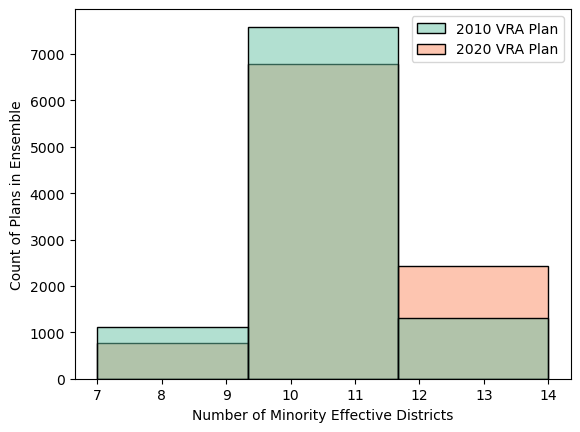

In [92]:
distinct_state = pd.DataFrame({'2010 VRA Plan': vra_2010.Distinct_equal,
                               '2020 VRA Plan': vra_2019.Distinct_equal,
                              })

sns.set_palette("Set2")
ax = sns.histplot(distinct_state, bins=3, alpha = .5, multiple='stack')
ax.set(xlabel='Number of Minority Effective Districts', 
       ylabel='Count of Plans in Ensemble')

plt.show()

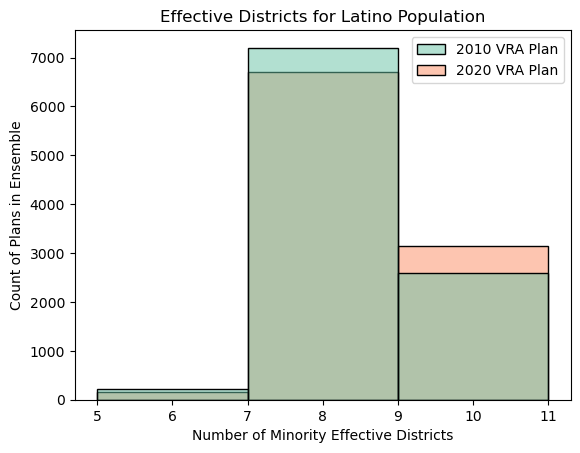

In [93]:
distinct_state = pd.DataFrame({'2010 VRA Plan': vra_2010.Latino_equal,
                               '2020 VRA Plan': vra_2019.Latino_equal,
                              })

sns.set_palette("Set2")
ax = sns.histplot(distinct_state, bins=3, alpha = .5, multiple='stack')
ax.set(xlabel='Number of Minority Effective Districts', 
       ylabel='Count of Plans in Ensemble',
      title ='Effective Districts for Latino Population'
      )

plt.show()

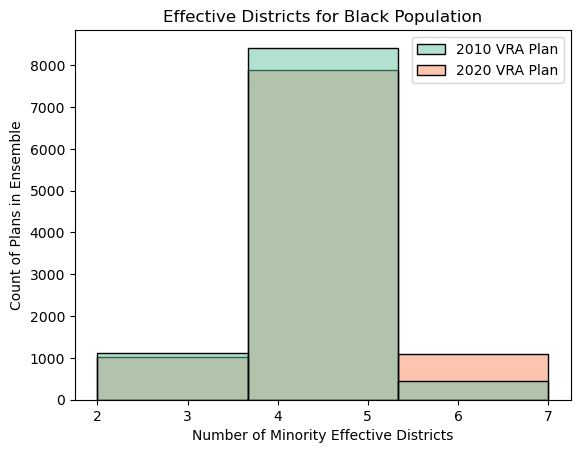

In [94]:
distinct_state = pd.DataFrame({'2010 VRA Plan': vra_2010.Black_equal,
                               '2020 VRA Plan': vra_2019.Black_equal,
                              })

sns.set_palette("Set2")
ax = sns.histplot(distinct_state, bins=3, alpha = .5, multiple='stack')
ax.set(xlabel='Number of Minority Effective Districts', 
       ylabel='Count of Plans in Ensemble',
      title='Effective Districts for Black Population'
      )

plt.show()

## Where should the 2 new districts go?

If we now think ahead to the upcoming cycle and consider options for where the two new districts might go, it’s important to remember that the placement of these districts is crucial to fair representation. 


In [159]:
# base ensemble
dist_per_county_2010_base = pd.read_csv('Outputs/district_count_per_county_Texas_2010_run_county_aware_proposal.csv').set_index('CNTY_x')
dist_per_county_2019_base = pd.read_csv('Outputs/district_count_per_county_Texas_2019_run_county_aware_proposal.csv').set_index('CNTY_x')

# VRA conscious ensemble
dist_per_county_2019 = pd.read_csv('Outputs/district_count_per_county_Texas_2019_run_county_aware_proposal_inclusion.csv').set_index('CNTY_x')

count_diff = dist_per_county_2019.mean(axis=1) - dist_per_county_2010_base.mean(axis=1)
count_diff = count_diff.reset_index()
count_diff.columns = ['CNTY_x', 'district_diff']


count_diff_base = dist_per_county_2019_base.mean(axis=1) - dist_per_county_2010_base.mean(axis=1)
count_diff_base = count_diff_base.reset_index()
count_diff_base.columns = ['CNTY_x', 'district_diff']



In [221]:
# map county ids to names for counties of interest
county_id2name = {113: 'Dallas',
#                   85: 'Collin',
#                   121: 'Denton',
#                   257: 'Kaufman',
#                   397: 'Rockwall',
                  
                  201: 'Harris',
#                   157: 'Fort Bend',
#                   339: 'Montgomery',
                  
                  453: 'Travis',
                  209: 'Hays',
                  491: 'Williamson'
                 }

### Comparison of Population Based Ensembles

The maps below illustrate the difference in the average number of districts per county in our ensembles when we compare 2010 plans to 2020 plans. The green regions correspond to areas where we’d expect to see a higher number of districts in 2020 than 2010, and the brown areas are counties where we’d expect to see a decrease in the number of districts.

The map below is based on ensembles that are created with the following considerations:

* population balance
* contiguity
* county line preservation


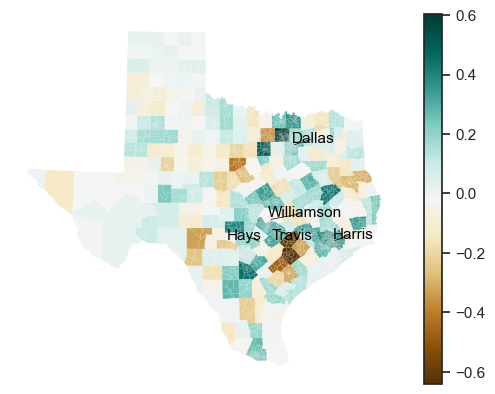

In [223]:
state_gdf.merge(count_diff_base, on='CNTY_x', how='left').plot('district_diff', 
                                                          cmap='BrBG',
                                                          edgecolor=(1,1,1,0.05),
                                                         legend=True
                                                         )
plt.axis("off")


labels = gpd.GeoDataFrame(geometry=state_gdf.geometry)
labels['CNTY_x'] = state_gdf.CNTY_x
labels['county_name'] = labels.CNTY_x.map(county_id2name)
labels = labels.drop_duplicates('county_name').dropna()

labels['rep'] = labels.geometry.representative_point()
labels.set_geometry("rep", inplace=True)


texts = []

for x, y, label in zip(labels.geometry.x, labels.geometry.y, labels["county_name"]):
    texts.append(plt.text(x, y, label, fontsize = 11, color = 'black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
plt.show()

### Comparison of Population & VRA Based Ensembles

The map below is based on ensembles that are created with the following considerations:

* population balance
* contiguity
* county line preservation

AND

* preferentially selecting plans with minority effective districts that are equal to or exceed the amount in the enacated plan

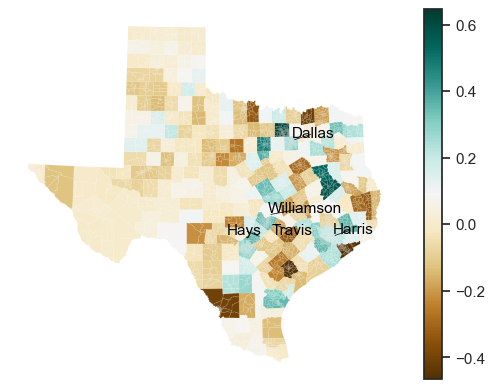

In [222]:
state_gdf.merge(count_diff, on='CNTY_x', how='left').plot('district_diff', 
                                                          cmap='BrBG',
                                                          edgecolor=(1,1,1,0.05),
                                                         legend=True
                                                         )
plt.axis("off")


labels = gpd.GeoDataFrame(geometry=state_gdf.geometry)
labels['CNTY_x'] = state_gdf.CNTY_x
labels['county_name'] = labels.CNTY_x.map(county_id2name)
labels = labels.drop_duplicates('county_name').dropna()

labels['rep'] = labels.geometry.representative_point()
labels.set_geometry("rep", inplace=True)


texts = []

for x, y, label in zip(labels.geometry.x, labels.geometry.y, labels["county_name"]):
    texts.append(plt.text(x, y, label, fontsize = 11, color = 'black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    
plt.show()

In the top map, we consider the population differences over the last decade, and the green regions correspond to areas that the ensemble analysis indicates could be likely candidates for adding a new district. 

However, if we create a 2020 ensemble of plans by prioritizing the inclusion of more minority effective districts, the landscape of options change when this constraint is added. For example, when accounting only for population, both Hays and Travis counties, both of which encompass parts of Austin, are potential candidates for a new district. But if we want to maximize minority opportunity districts, then on the second map, we can see that Hays county is a much better option than Travis county. Similarly, it would be better to place a new district in some of the Dallas suburbs shaded in green illustrated in the second map to better comply with the Voting Rights Act. 

The GerryChain library allows for nuanced analysis on possible tradeoffs when considering where the new districts could be placed. 
